<a id='top'></a>
# Using Teranet data for Parking Lot Taxation research

**This notebook presents a sample of how real estate sales data from the Teranet dataset could be used for the research of Parking Lot Taxation.**

This notebook aims to demonstrate how point sales data from Teranet dataset could be combined with data on parking lots and provide spatially-related context on the value of property transactions occuring in the immediate vicinity of a given parking lot in Toronto (or other Ontario cities) in a given period of time (1980-2017).

The proposed logic used in this example:

* Load the shapefile containing the subset of Teranet dataset that contains all transactions recorded in Toronto (spatial information is recorded as coordinates of each transaction)

* Load the dataset of parking (spatial information is recorded as address of each parking lot)

* For this example, the first parking lot (first row) of the parking lot dataset is used to illustrate the potential for connection with the real estate sales data:

    * First row from the parking lot dataset is taken
    
    * Address information for the record is manually converted to GIS coordinates (taken from Google maps)
    
    * A 1,000-m buffer is drawn around the parking lot
    
    * All real estate transactions from the buffer that occured in 2017 are selected from the Teranet dataset, price distribution is displayed. Mean and median price are displayed monthly
    
    * 5-year subset of sales points that fall within the 1,000-m buffer is taken from real estate sales dataset, mean and median price are displayed per annum
    
* The proposed workflow can easily be replicated for any number of parking lots and different time criteria, as long as coordinates of the parking lots can be provided. Size of buffer can be adjusted. Additional attributes can be added to the analysis.

    * The coordinate pair used in this example was entered by hand
    
    * Geocoding can be used to convert parking lot addresses into GIS coordinates.

# 1. Import libraries

Back to the [top](#top)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import geopy

# 2. Load the subset of Teranet dataset

Back to the [top](#top)

All property transactions recorded in Toronto.

#### Set path

In [2]:
sales_points_path = 'Data/geo/teranet_subsets/Toronto/with_lu/'

#### Read the shapefile into a GeoDataFrame

Index is set to registration date.

In [3]:
%%time
db_sales_points = gpd.read_file(sales_points_path)
db_sales_points['registrati'] = pd.to_datetime(db_sales_points['registrati'])
db_sales_points.set_index('registrati', inplace=True)
db_sales_points.head()

Wall time: 3min 51s


#### Subset transactions that occured in July 2017

In [4]:
start_date = '2017-01-01'
end_date = '2017-12-31'

db_sales_points_subset = db_sales_points.loc[start_date:end_date]
print("{0} total records in the subset of transactions that occured in Toronto from {1} to {2}"
      .format(
              len(db_sales_points_subset),
              start_date,
              end_date
              ))
db_sales_points_subset.head()

55630 total records in the subset of transactions that occured in Toronto from 2017-01-01 to 2017-12-31


,row_num,decade,year,lro_num,pin,considerat,postal_cod,province,unitno,street_nam,...,street_suf,street_num,x,y,index_lu,category,accuracy,index_neig,neighbourh,geometry
registrati,,,,,,,,,,,,,,,,,,,,,
2017-01-04,7966687,201,2017,80,765470659,416291.0,None,ON,NaN,Richmond Street West,...,NaN,318.0,-79.392008,43.64905,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2017-01-05,7967007,201,2017,80,765470522,578691.0,None,ON,NaN,Richmond St West,...,NaN,318.0,-79.392008,43.64905,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2017-01-05,7966998,201,2017,80,765470613,578691.0,None,ON,NaN,None,...,NaN,NaN,-79.392008,43.64905,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2017-01-09,7969659,201,2017,80,765470306,395420.0,None,ON,NaN,Richmond Street West,...,NaN,318.0,-79.392008,43.64905,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2017-01-11,7971789,201,2017,80,765470012,186241.0,None,ON,NaN,Richmond Street West,...,NaN,318.0,-79.392008,43.64905,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)


# 3. Load the parking lot dataset

Back to the [top](#top)

Dataset containing the information about parking lots in Toronto.

#### Set path

In [5]:
parking_path = 'Data/parking_lots/compiled06.xls'

#### Read the Excel file into a DataFrame

Index is set to registration date.

In [6]:
parking = pd.read_excel(parking_path)
parking.head()

,LOTID,AREA,SUBAREA,FACILITYCODE,LOTID2004,YEAR,TYPE,CLASS,FLOORS,PRIVATE_RANDOM,...,MONTHLY_RANDOM,MONTHLY_RESERVED,SATURDAY,SUNDAY,HOLIDAY,EVENTS,CONDITION,CONTROL,USER,SURVEY_ADDRESS
0,1010260.0,1.0,1.0,260,1010260,2006.0,1.0,7.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Tenants,480 Bloor St.
1,1010275.0,1.0,1.0,MERGED WITH 1012570,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1010280.0,1.0,1.0,28,1010280,2006.0,1.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Car Wash,250 Albany Ave.
3,1012570.0,1.0,1.0,2570,1012570,2006.0,1.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Wing's food Product,275 Dupont St.
4,1013650.0,1.0,1.0,3650,1013650,2006.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tenants,16 Howland Ave.


#### Manually find the coordinates for the address of the first parking lot

Taken from [Google maps](https://www.google.ca/maps/place/480+Bloor+St+W,+Toronto,+ON+M5S+1X8/@43.6645464,-79.4097829,176a,35y,39.45t/data=!3m1!1e3!4m5!3m4!1s0x882b3493e419bf3b:0xdcd9d1cd31f6b92c!8m2!3d43.665594!4d-79.4095102?hl=en)




**480 Bloor St.:** -79.409513, 43.665595


In [7]:
parking_point = parking.loc[[0]]
parking_point_geom = Point([-79.409513, 43.665595])     # using Point from shapely
parking_point['coordinates'] = parking_point_geom
parking_point_gdf = gpd.GeoDataFrame(parking_point, geometry='coordinates')
parking_point_gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
parking_point_gdf

,LOTID,AREA,SUBAREA,FACILITYCODE,LOTID2004,YEAR,TYPE,CLASS,FLOORS,PRIVATE_RANDOM,...,MONTHLY_RESERVED,SATURDAY,SUNDAY,HOLIDAY,EVENTS,CONDITION,CONTROL,USER,SURVEY_ADDRESS,coordinates
0,1010260.0,1.0,1.0,260,1010260,2006.0,1.0,7.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,Tenants,480 Bloor St.,POINT (-79.409513 43.665595)


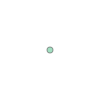

In [8]:
parking_point_gdf.loc[0, 'coordinates']

 # 4. Joining the two datasets
 
 Back to the [top](#top)

#### Create a GeoDataFrame with the 1,000m buffer around the first parking lot

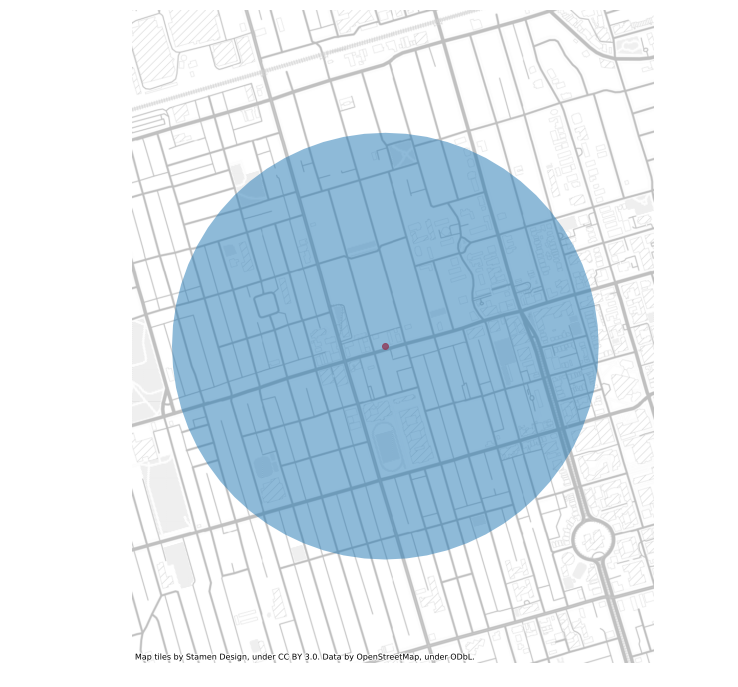

In [9]:
buffer_size = 1000     # size of buffer to draw around the parking lot, in meters

buffer_gdf = gpd.GeoDataFrame(parking_point_gdf.to_crs(epsg=3857).buffer(buffer_size))
buffer_gdf = buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')
buffer_gdf.crs = {'init': 'epsg:3857'}
buffer_gdf = buffer_gdf.to_crs(epsg=4326)

f, ax = plt.subplots(1, figsize=(12, 12))
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
plt.show()

#### Plot all transactions and the parking lot with a 1,000m buffer

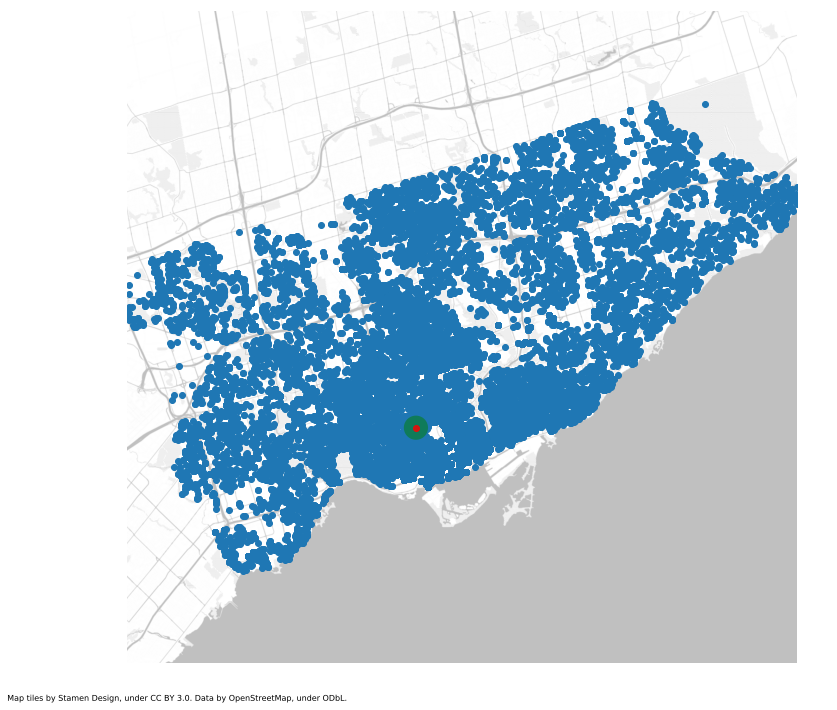

Wall time: 25.6 s


In [10]:
%%time
f, ax = plt.subplots(1, figsize=(12, 12))
db_sales_points_subset.to_crs(epsg=3857).plot(ax=ax)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.5)
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = db_sales_points_subset.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX, maxX)
ax.set_ylim(minY, maxY)
plt.show()

#### Validating CRS

In [11]:
db_sales_points_subset.crs

{'init': 'epsg:4326'}

In [12]:
buffer_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

#### Perform the spatial join

In [13]:
%%time
parking_sales_join = gpd.sjoin(db_sales_points_subset, buffer_gdf, how='inner', op='within')
print('{0} transactions occured from {1} to {2} within the boundary of the buffer.'.
     format(
             len(parking_sales_join),
             start_date,
             end_date
            ))
print("Saved in a new geodataframe 'parking_sales_join'.")

C:\Anaconda\envs\gds\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


151 transactions occured from 2017-01-01 to 2017-12-31 within the boundary of the buffer.
Saved in a new geodataframe 'parking_sales_join'.
Wall time: 2.99 s


# Transactions within 1,000m from the parking lot

#### Plot the subset from the join

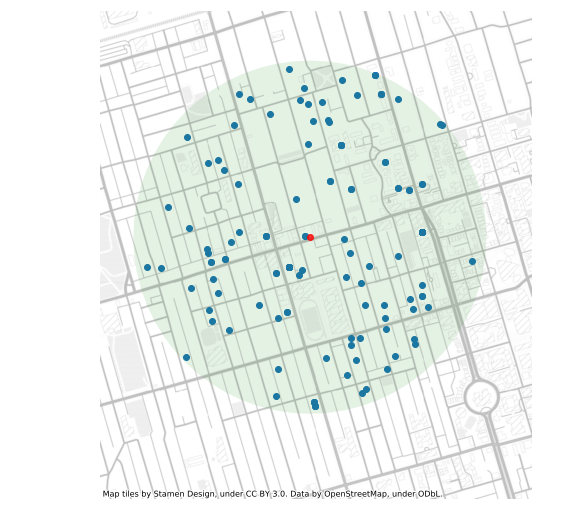

Wall time: 3.19 s


In [14]:
%%time
f, ax = plt.subplots(1, figsize=(9, 9))
parking_sales_join.to_crs(epsg=3857).plot(ax=ax)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = parking_sales_join.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)
plt.show()

#### Mean and median price

In [15]:
print("Mean price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_join['considerat'].mean(), 2)
             ))
print("Median price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_join['considerat'].median(), 2)
             ))

Mean price of the 151 transactions that occured within 1000 meters of the parking lot between 2017-01-01 and 2017-12-31:
1,428,093.28$
Median price of the 151 transactions that occured within 1000 meters of the parking lot between 2017-01-01 and 2017-12-31:
1,365,000.0$


#### Context from price distribution

C:\Anaconda\envs\gds\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


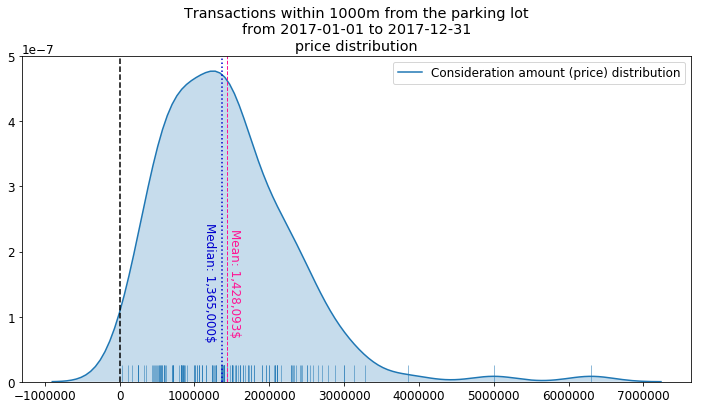

In [16]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


sales_mean = int(parking_sales_join['considerat'].mean())
sales_median = int(parking_sales_join['considerat'].median())

f, ax = plt.subplots(1, figsize=(12,6))
ax = sns.kdeplot(parking_sales_join['considerat'], shade=True)
ax = sns.rugplot(parking_sales_join['considerat'], alpha=0.5)
ax.axvline(0, linestyle='--', color='black')
ax.axvline(sales_mean, linestyle='--', linewidth=1, color='deeppink')
ax.axvline(sales_median, linestyle=':', color='mediumblue')
ax.text(sales_mean + 20000, 0.00000022, 'Mean: {:,}$'.format(sales_mean), color='deeppink', rotation=-90)
ax.text(sales_median - 250000, 0.00000023, 'Median: {:,}$'.format(sales_median), color='mediumblue', rotation=-90)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nprice distribution"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
plt.show()

#### Overall mean vs mean of monthly means

There can be a discrepancy in values if mean and median are calculated from the monthly means and medians vs overall mean and median.

In [17]:
parking_sales_join['considerat'].mean()

1428093.2781456953

In [18]:
parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).mean().mean()

1405265.8709575213

#### Context from monthly means and medians

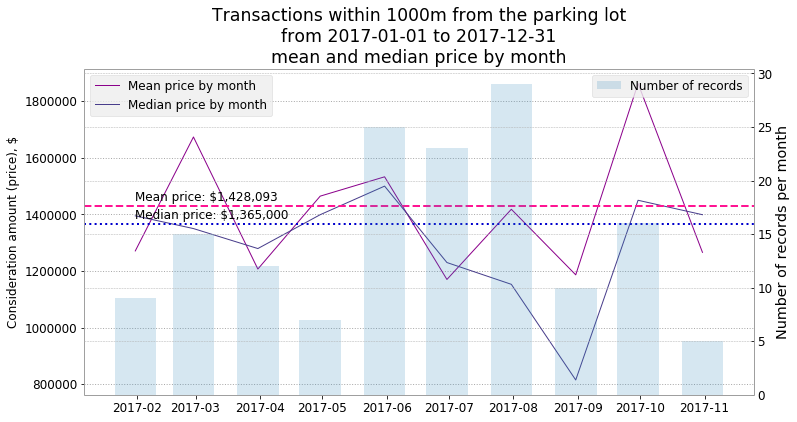

In [19]:
monthly_means = parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).mean()
monthly_medians = parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).median()
monthly_counts = parking_sales_join['considerat'].groupby(pd.Grouper(freq="M")).count()

f, ax1 = plt.subplots(1, figsize=(12, 6))
plt.style.use('bmh')
ax1.plot(monthly_means, linestyle='-', linewidth=1, color='darkmagenta')
ax1.plot(monthly_medians, linestyle='-', linewidth=1, color='darkslateblue')
ax1.axhline(sales_mean, linewidth=2, linestyle='--', color='deeppink')
ax1.axhline(sales_median, linewidth=2, linestyle=':', color='mediumblue')
ax1.text('2017-01-31', sales_mean + 20000, 'Mean price: ${:,}'.format(sales_mean))
ax1.text('2017-01-31', sales_median + 20000, 'Median price: ${:,}'.format(sales_median))
ax1.yaxis.grid(color='darkgray', linewidth=1, linestyle=':')
ax1.legend(['Mean price by month', 'Median price by month'])
ax1.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nmean and median price by month"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
ax1.set_ylabel("Consideration amount (price), $")

ax2 = ax1.twinx()
ax2.bar(monthly_counts.index, monthly_counts, label='Number of records', width=20, alpha=0.2)
ax2.set_ylabel("Number of records per month")
ax2.legend(loc='upper right')

plt.show()

## Transactions within 1,000m, 5 year history

In [20]:
start_date = '2013-01-01'
end_date = '2017-12-31'

db_sales_points_5yr_subset = db_sales_points.loc[start_date:end_date]
print("{0} total records in the subset of transactions that occured in Toronto from {1} to {2}"
      .format(
              len(db_sales_points_5yr_subset),
              start_date,
              end_date
              ))
db_sales_points_5yr_subset.head()

332002 total records in the subset of transactions that occured in Toronto from 2013-01-01 to 2017-12-31


,row_num,decade,year,lro_num,pin,considerat,postal_cod,province,unitno,street_nam,...,street_suf,street_num,x,y,index_lu,category,accuracy,index_neig,neighbourh,geometry
registrati,,,,,,,,,,,,,,,,,,,,,
2014-10-10,7222858,201,2014,80,214120219,3900000.0,M5V1X2,ON,NaN,Richmond,...,NaN,340.0,-79.392961,43.648875,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3929612490533 43.6488748977188)
2016-11-21,7925107,201,2016,80,765470217,431729.0,None,ON,NaN,Richmond Street. West,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925110,201,2016,80,765470149,323784.0,None,ON,NaN,Richmond Street,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925098,201,2016,80,765470244,547963.0,None,ON,NaN,Richmond Street West,...,NaN,318.0,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)
2016-11-21,7925113,201,2016,80,765470152,266791.0,None,ON,NaN,None,...,NaN,NaN,-79.392008,43.649050,146301,Residential,Within 50 metres,8,Waterfront Communities-The Island,POINT (-79.3920080297622 43.64904964750301)


#### Perform the spatial join

In [21]:
%%time
db_sales_points_5yr_subset.crs = {'init': 'epsg:4326', 'no_defs': True}
parking_sales_5yr_join = gpd.sjoin(db_sales_points_5yr_subset, buffer_gdf, how='inner', op='within')
print('{0} transactions occured from {1} to {2} within the boundary of the buffer.'.
     format(
             len(parking_sales_5yr_join),
             start_date,
             end_date
            ))
print("Saved in a new geodataframe 'parking_sales_5yr_join'.")

1223 transactions occured from 2013-01-01 to 2017-12-31 within the boundary of the buffer.
Saved in a new geodataframe 'parking_sales_5yr_join'.
Wall time: 16 s


#### Plot the subset from the join

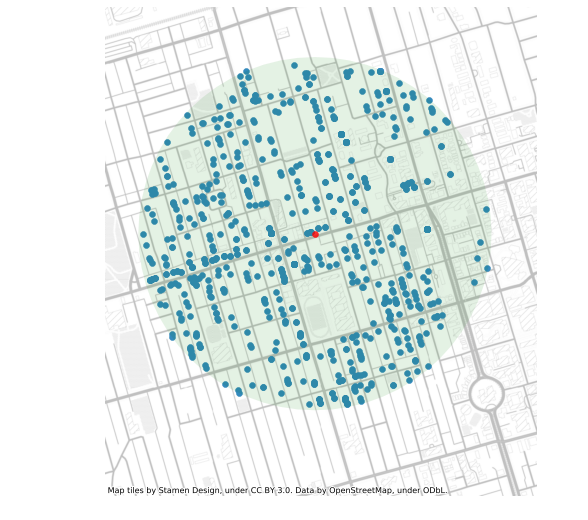

Wall time: 3.08 s


In [22]:
%%time
f, ax = plt.subplots(1, figsize=(9, 9))
parking_sales_5yr_join.to_crs(epsg=3857).plot(ax=ax)
buffer_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=0.1)
parking_point_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.8)
ctx.add_basemap(ax, url=ctx.sources.ST_TONER_BACKGROUND,
                alpha=0.25)
ax.set_axis_off()
plt.axis('equal')
minX, minY, maxX, maxY = parking_sales_join.to_crs(epsg=3857).total_bounds
ax.set_xlim(minX - 500, maxX + 500)
ax.set_ylim(minY - 500, maxY + 300)
plt.show()

In [23]:
print("Mean price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_5yr_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_5yr_join['considerat'].mean(), 2)
             ))
print("Median price of the {0} transactions that occured within {1} meters of the parking lot between {2} and {3}:\n{4:,}$"
     .format(
            len(parking_sales_5yr_join),
            buffer_size,
            start_date,
            end_date,
            round(parking_sales_5yr_join['considerat'].median(), 2)
             ))

Mean price of the 1223 transactions that occured within 1000 meters of the parking lot between 2013-01-01 and 2017-12-31:
1,901,362.02$
Median price of the 1223 transactions that occured within 1000 meters of the parking lot between 2013-01-01 and 2017-12-31:
859,900.0$


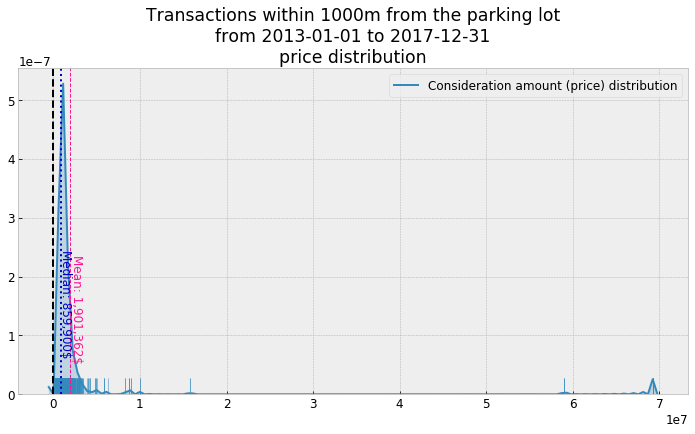

In [24]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


sales_mean = int(parking_sales_5yr_join['considerat'].mean())
sales_median = int(parking_sales_5yr_join['considerat'].median())

f, ax = plt.subplots(1, figsize=(12,6))
ax = sns.kdeplot(parking_sales_5yr_join['considerat'], shade=True)
ax = sns.rugplot(parking_sales_5yr_join['considerat'], alpha=0.5)
ax.axvline(0, linestyle='--', color='black')
ax.axvline(sales_mean, linestyle='--', linewidth=1, color='deeppink')
ax.axvline(sales_median, linestyle=':', color='mediumblue')
ax.text(sales_mean + 20000, 0.00000022, 'Mean: {:,}$'.format(sales_mean), color='deeppink', rotation=-90)
ax.text(sales_median - 250000, 0.00000023, 'Median: {:,}$'.format(sales_median), color='mediumblue', rotation=-90)
ax.legend(['Consideration amount (price) distribution'])
ax.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nprice distribution"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
plt.show()

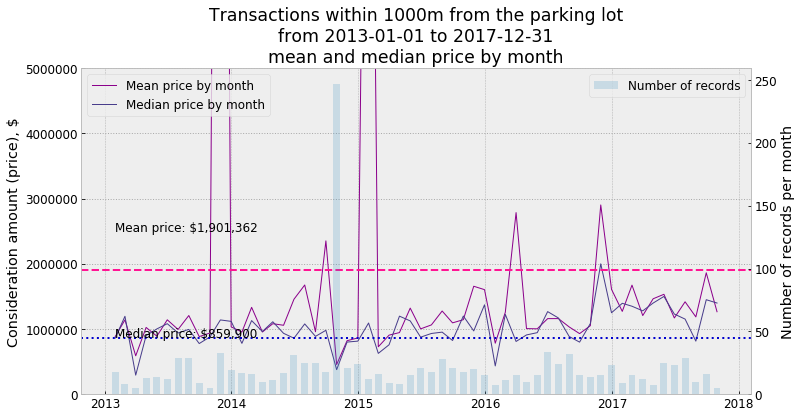

In [25]:
monthly_means = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).mean()
monthly_medians = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).median()
monthly_counts = parking_sales_5yr_join['considerat'].groupby(pd.Grouper(freq="M")).count()

f, ax1 = plt.subplots(1, figsize=(12, 6))
plt.style.use('bmh')
ax1.plot(monthly_means, linestyle='-', linewidth=1, color='darkmagenta')
ax1.plot(monthly_medians, linestyle='-', linewidth=1, color='darkslateblue')
ax1.axhline(sales_mean, linewidth=2, linestyle='--', color='deeppink')
ax1.axhline(sales_median, linewidth=2, linestyle=':', color='mediumblue')
ax1.text('2013-01-31', sales_mean + 600000, 'Mean price: ${:,}'.format(sales_mean))
ax1.text('2013-01-31', sales_median + 20000, 'Median price: ${:,}'.format(sales_median))
ax1.yaxis.grid(color='darkgray', linewidth=1, linestyle=':')
ax1.set_title("Transactions within {0}m from the parking lot\nfrom {1} to {2}\nmean and median price by month"
            .format(
                    buffer_size,
                    start_date,
                    end_date))
ax1.set_ylabel("Consideration amount (price), $")
ax1.set_ylim(0, 5000000)
ax1.legend(['Mean price by month', 'Median price by month'], loc='upper left')

ax2 = ax1.twinx()
ax2.bar(monthly_counts.index, monthly_counts, label='Number of records', width=20, alpha=0.2)
ax2.set_ylabel("Number of records per month")
ax2.yaxis.grid(linewidth=0)
ax2.legend(loc='upper right')

plt.show()